In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `C:\Users\Owner`


In [2]:
Pkg.add(["CairoMakie","LinearAlgebra","Distributions","Convex","SCS"])

   Resolving package versions...
  No Changes to `C:\Users\Owner\Project.toml`
  No Changes to `C:\Users\Owner\Manifest.toml`


In [3]:
using CairoMakie, LinearAlgebra, Convex, SCS, Random, Statistics

In [5]:
Random.seed!(42)
n = 100  
M = 20   
x = LinRange(-2, 2, n)
y = x.^2 .+ 0.1 * randn(n) 

100-element Vector{Float64}:
 3.9636642518548224
 3.8651900464222333
 3.6517988255746663
 3.498718653347815
 3.461285813724127
 3.280405191926663
 3.003117005411837
 2.801749885703809
 2.600116358739774
 2.6820641166162837
 2.46455357693801
 2.5037819387443343
 2.339072701296418
 ⋮
 2.380607721658704
 2.5220107815649744
 2.779869855891311
 2.811455865633508
 2.798601093142301
 3.1153650180484336
 3.126619578547451
 3.4832972023704625
 3.509182582032138
 3.6522232353831887
 3.835968984839975
 4.010477079178892

In [6]:
A = hcat([x .^ p for p in 0:M]...)

100×21 Matrix{Float64}:
 1.0  -2.0      4.0      -8.0      …  -524288.0            1.04858e6
 1.0  -1.9596   3.84002  -7.52488          -3.55766e5      6.97157e5
 1.0  -1.91919  3.6833   -7.06896          -2.39469e5      4.59587e5
 1.0  -1.87879  3.52984  -6.63183     -159837.0            3.003e5
 1.0  -1.83838  3.37966  -6.2131           -1.05752e5      1.94412e5
 1.0  -1.79798  3.23273  -5.81239  …   -69328.4            1.24651e5
 1.0  -1.75758  3.08907  -5.42928      -45016.0        79119.1
 1.0  -1.71717  2.94868  -5.06339      -28937.5        49690.6
 1.0  -1.67677  2.81155  -4.71432      -18407.1        30864.4
 1.0  -1.63636  2.67769  -4.38167      -11580.2        18949.4
 1.0  -1.59596  2.54709  -4.06505  …    -7201.38       11493.1
 1.0  -1.55556  2.41975  -3.76406       -4424.1         6881.93
 1.0  -1.51515  2.29568  -3.47831       -2683.28        4065.57
 ⋮                                 ⋱                       ⋮
 1.0   1.55556  2.41975   3.76406        4424.1         6881

In [7]:
function fitlq(A, y)
    return pinv(A) * y  # Least squares -pseudo inverse
end

fitlq (generic function with 1 method)

In [8]:
function lasso(A, y, λ1)
    x = Variable(size(A, 2))  # LASSO coefficients
    problem = minimize(norm(A * x - y, 2) + λ1 * norm(x, 1))
    solve!(problem, SCS.Optimizer; silent = true)
    return vec(evaluate(x))
end

lasso (generic function with 1 method)

In [9]:
n_realizations = 100
coeffs_ls = zeros(M+1, n_realizations)
coeffs_lasso = zeros(M+1, n_realizations)

for i in 1:n_realizations
    y_perturbed = x.^2 .+ 0.1 * randn(n)  # Perturbed data
    
    # Perform Least Squares and LASSO
    coeffs_ls[:, i] = fitlq(A, y_perturbed)
    coeffs_lasso[:, i] = lasso(A, y_perturbed, 0.1)  # LASSO with λ1 = 0.1
end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\Owner\.julia\packages\Makie\6c4lt\src\scenes.jl:229


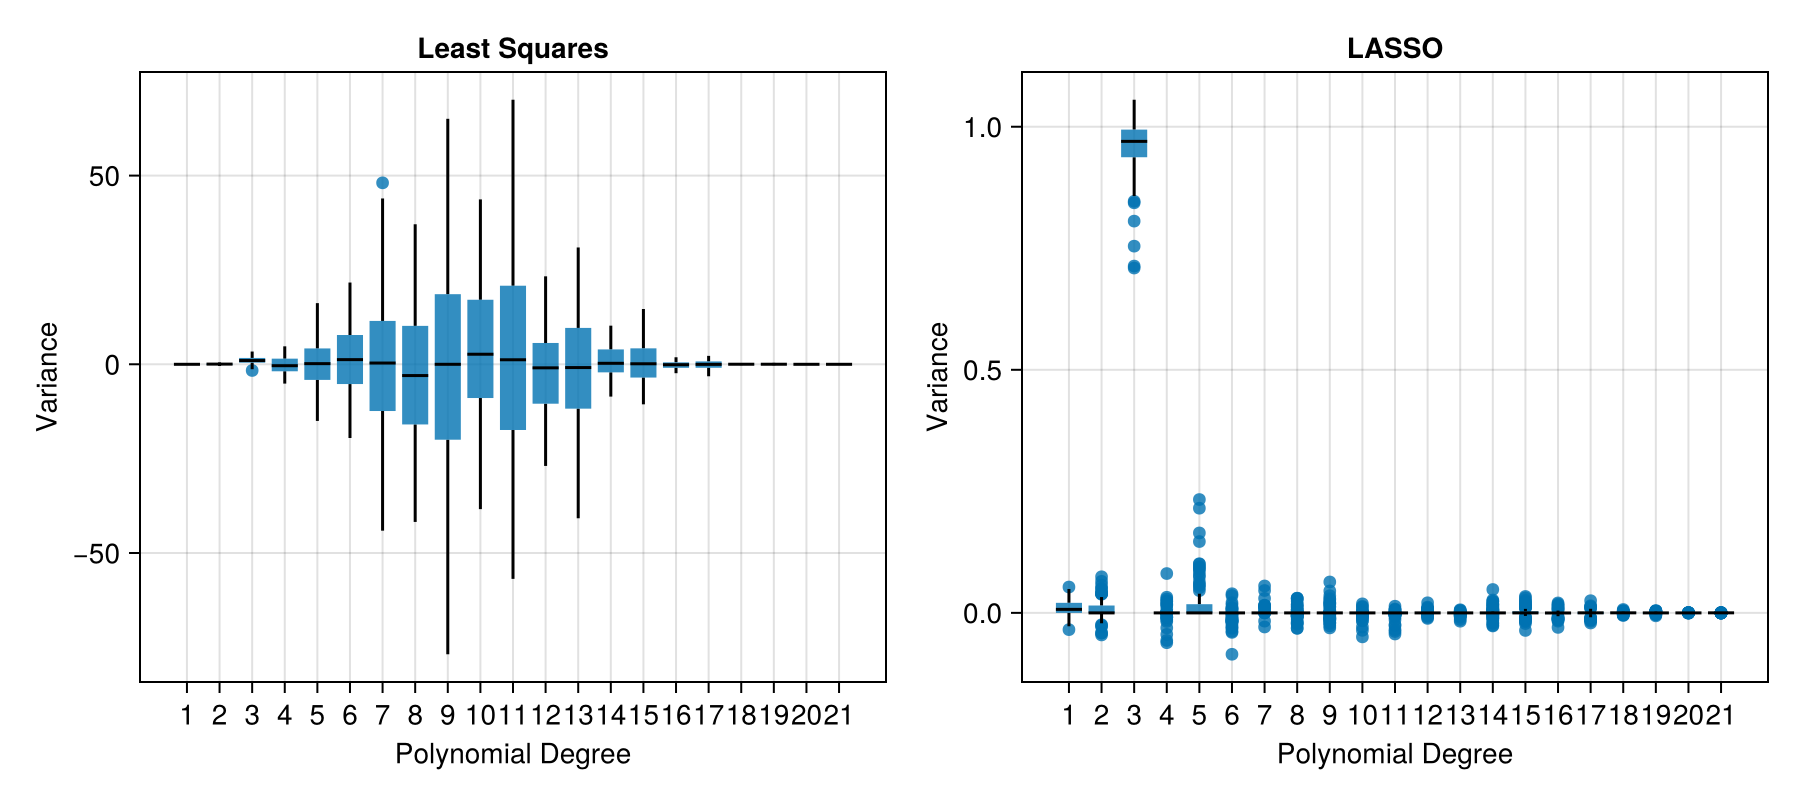

In [10]:
fig = Figure(resolution = (900, 400))

ax_ls = Axis(fig[1, 1], title = "Least Squares", xlabel = "Polynomial Degree", ylabel = "Variance", xticks = 1:(M+1))
boxplot!(ax_ls, repeat(1:(M+1), n_realizations), vec(coeffs_ls))

ax_lasso = Axis(fig[1, 2], title = "LASSO", xlabel = "Polynomial Degree", ylabel = "Variance", xticks = 1:(M+1))
boxplot!(ax_lasso, repeat(1:(M+1), n_realizations), vec(coeffs_lasso))

fig

In [12]:
errors_ls = zeros(n_realizations)
errors_lasso = zeros(n_realizations)

for i in 1:n_realizations
    y_perturbed = x.^2 .+ 0.1 * randn(n)  # Perturbed data
    
    # Predicted values from the models
    y_pred_ls = A * coeffs_ls[:, i]
    y_pred_lasso = A * coeffs_lasso[:, i]
    
    # Calculate errors (normalized residuals)
    errors_ls[i] = norm(y_perturbed - y_pred_ls) / norm(y_perturbed)
    errors_lasso[i] = norm(y_perturbed - y_pred_lasso) / norm(y_perturbed)
end

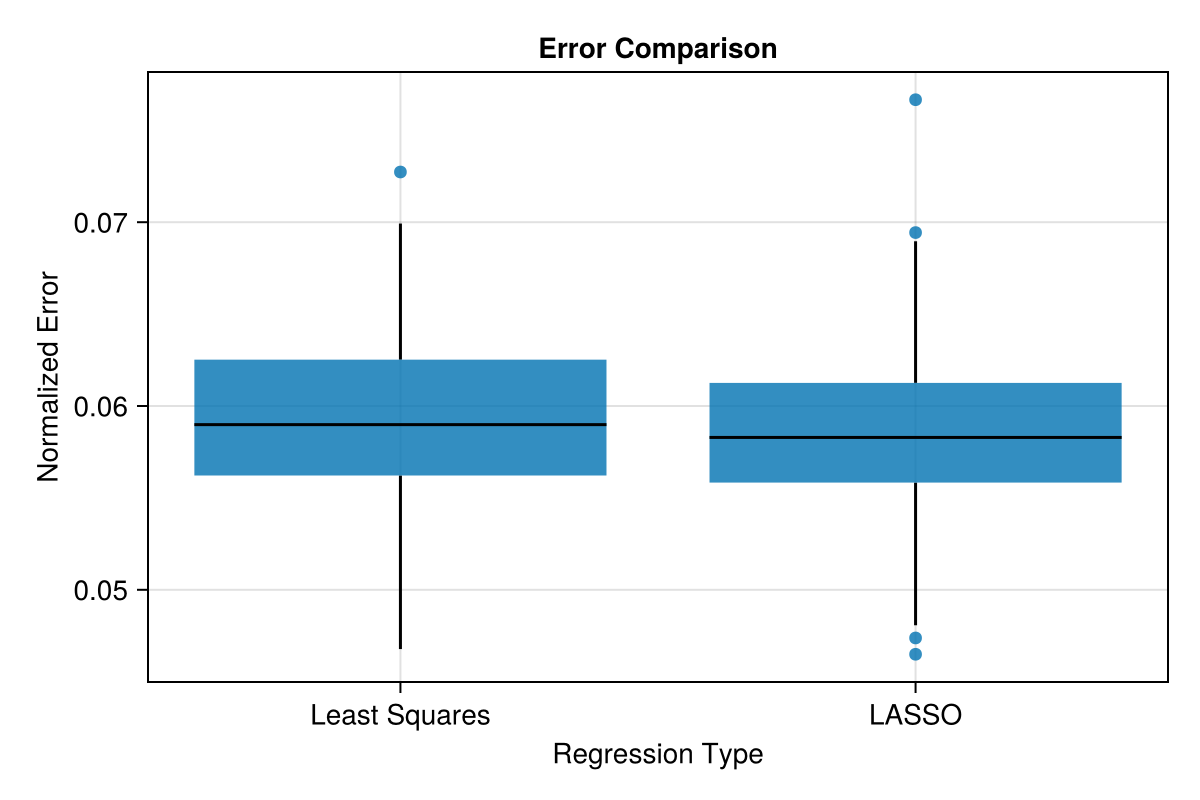

In [13]:
fig_error = Figure(size = (600, 400))
ax_error = Axis(fig_error[1, 1], title = "Error Comparison", xlabel = "Regression Type", ylabel = "Normalized Error")

boxplot!(ax_error, repeat([1, 2], n_realizations), vcat(errors_ls, errors_lasso))

ax_error.xticks = (1:2, ["Least Squares", "LASSO"])

fig_error

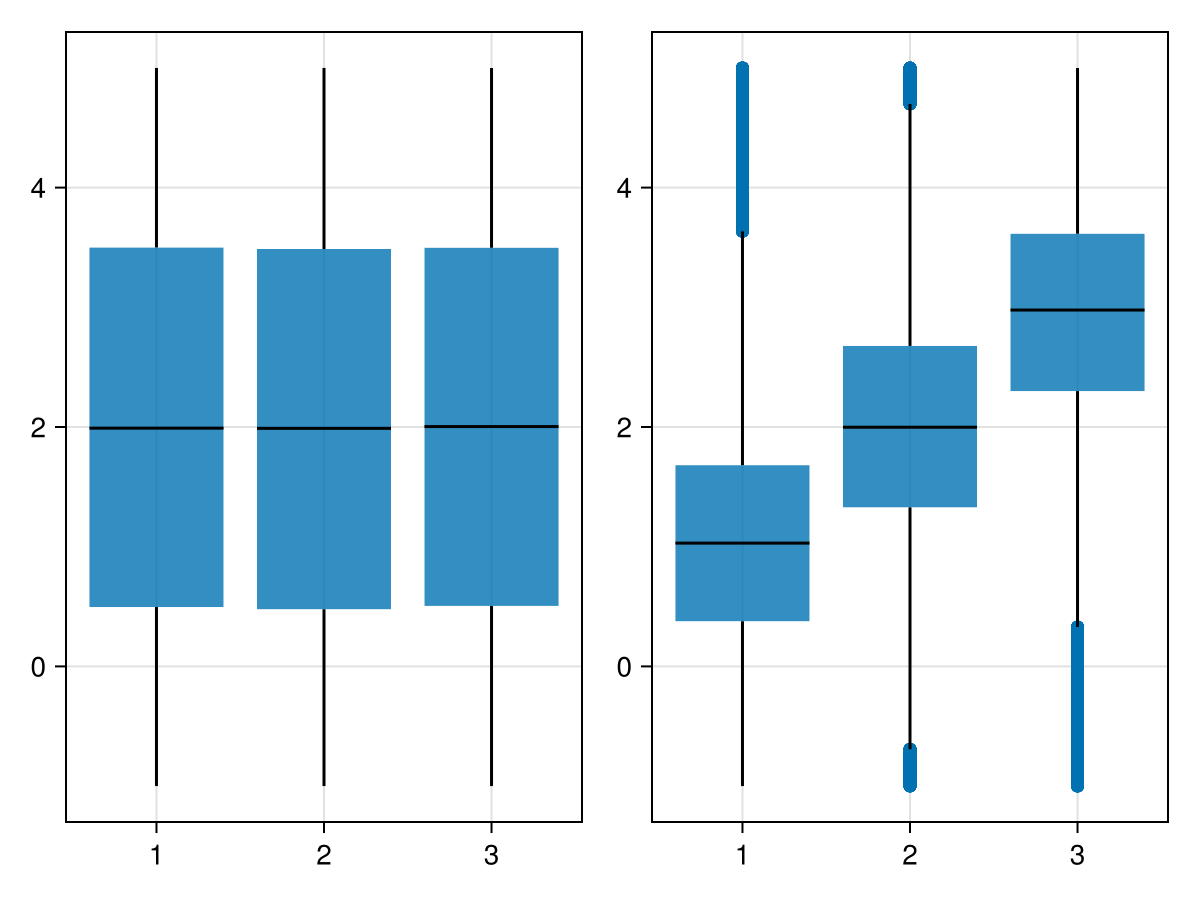

In [13]:
N = 100_000
x = rand(1:3, N)
y = rand(Uniform(-1, 5), N)

w = pdf.(Normal(), x .- y)

fig = Figure()

boxplot(fig[1,1], x, y)
boxplot(fig[1,2], x, y, weights = w)

fig

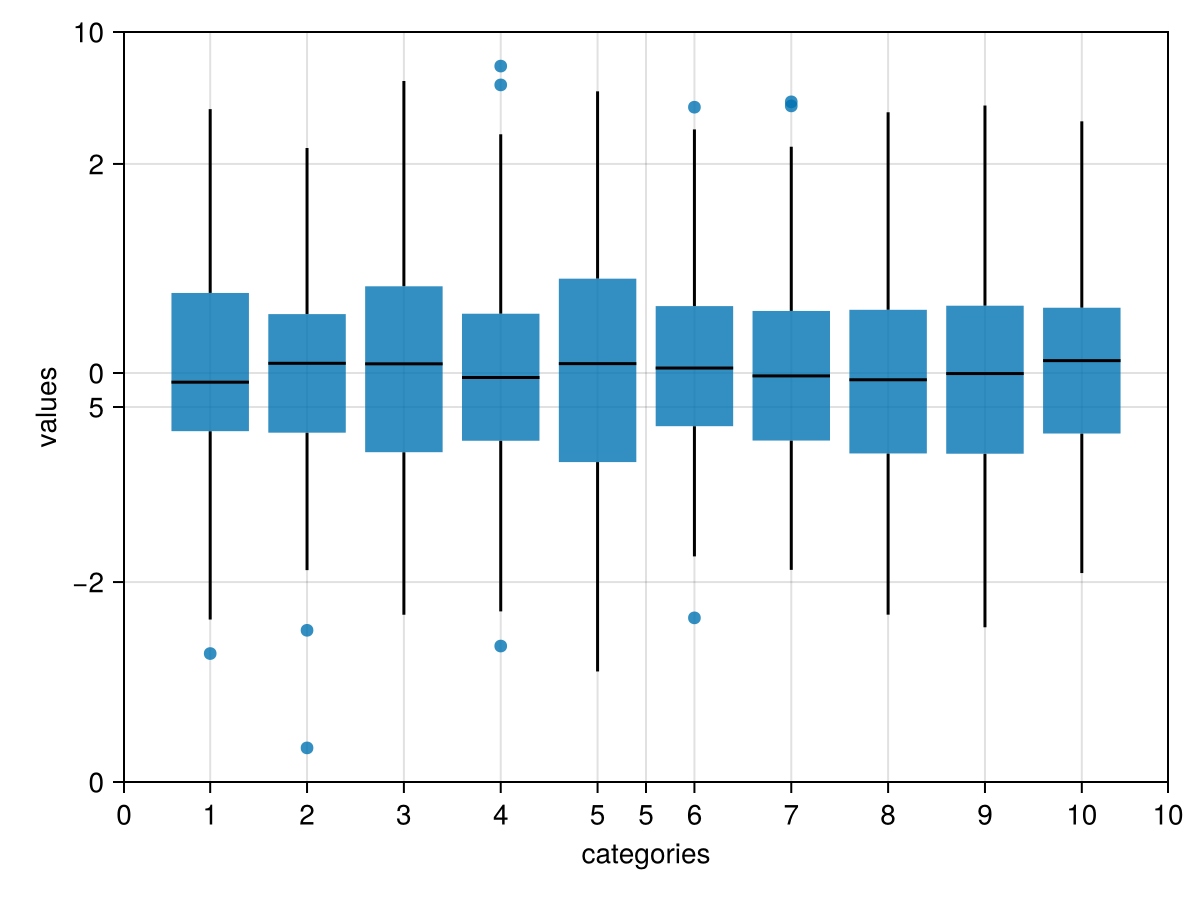

In [16]:
#https://docs.makie.org/v0.21/reference/plots/boxplot
using CairoMakie
fig = Figure()

categories = rand(1:10, 1000)
values = randn(1000)

ax_vert = Axis(fig[1,1];
    xlabel = "categories",
    ylabel = "values",
    xticks = (1:10))

ax_horiz = Axis(fig[1,1];)

boxplot!(ax_vert, categories, values) 

fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\Administrator\.julia\packages\Makie\6c4lt\src\scenes.jl:229


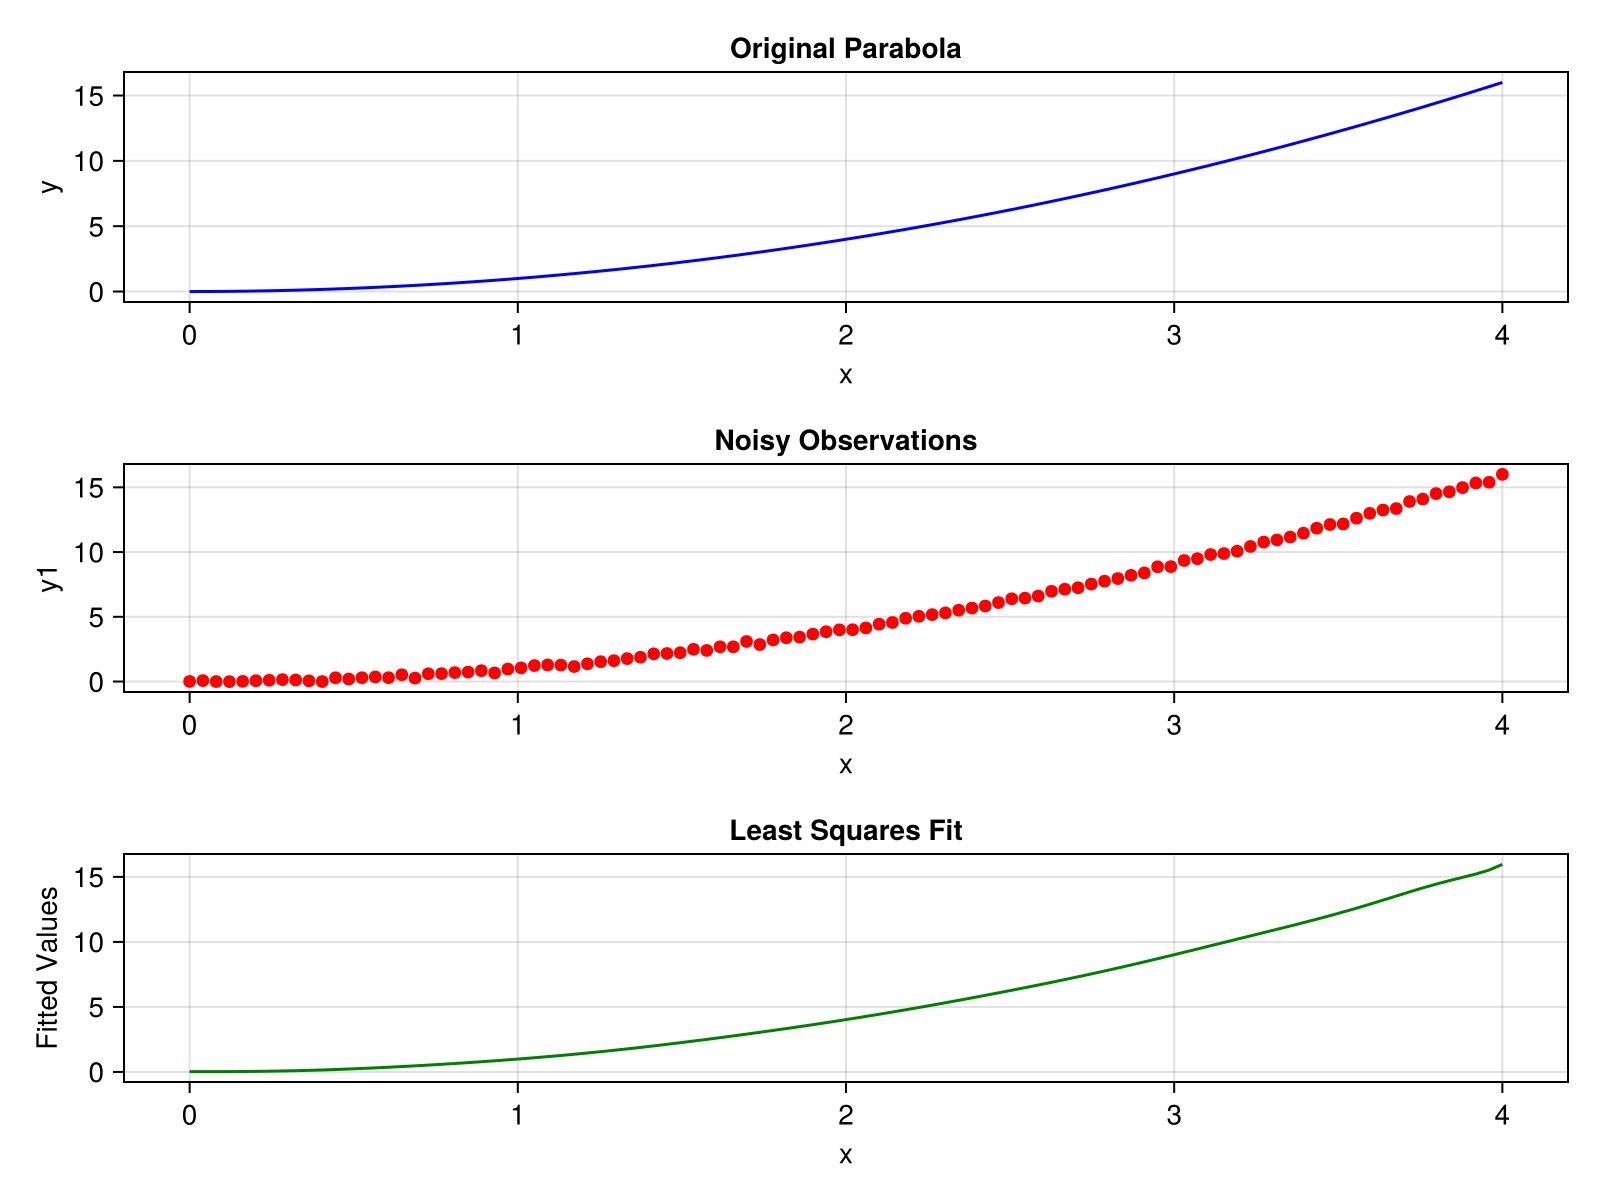

CairoMakie.Screen{IMAGE}


In [20]:
Calculate the fitted values
fitted_values = A * b1  # Reconstructed y values from fitted coefficients

fig = Figure(resolution = (800, 600))  

# Plot the original parabola
ax1 = Axis(fig[1, 1], title="Original Parabola", xlabel="x", ylabel="y")
lines!(ax1, x, y, color=:blue, label="Original y = x^2")

# Plot the noisy data
ax2 = Axis(fig[2, 1], title="Noisy Observations", xlabel="x", ylabel="y1")
scatter!(ax2, x, y1, color=:red, label="Noisy data (y1)")

# Plot the fitted values
ax3 = Axis(fig[3, 1], title="Least Squares Fit", xlabel="x", ylabel="Fitted Values")
lines!(ax3, x, fitted_values, color=:green, label="Fitted Least Squares")

display(fig)

In [17]:
b10ls = lasso(A[:,1:10],y1,0.1,0)
b10lq = fitlq(A[:,1:10],y1)

10-element Vector{Float64}:
  -0.03187234578280779
   1.4399027498486152
  -7.516368919117966
  19.92829066023225
 -24.005727230007636
  16.46085614614259
  -6.663032086381023
   1.5732797099562426
  -0.20016420396575185
   0.010596493353090153